<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов
**Заполните код в клетках и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1l3OtddjlKGGyl285bkzu4ulH5cXSnBdAkqR9VzB3Bgg/edit).**

In [16]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.4.1


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [17]:
df = pd.read_csv('../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [18]:
df.shape

(383, 7)

In [19]:
df.date = pd.to_datetime(df.date)

In [20]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [21]:
from fbprophet import Prophet

In [22]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [28]:
## ВАШ КОД для построения модели ##

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(train_df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
378,2016-01-16,2447.327542,2447.326659,2447.328391,1925.129453,2648.821729,389.764322,389.764322,389.764322,-169.014585,...,-169.014585,-169.014585,-169.014585,-860.099205,-860.099205,-860.099205,301.320297,301.320297,301.320297,2278.312956
379,2016-01-17,2449.791977,2449.791041,2449.792886,2092.617590,2837.208125,389.764322,389.764322,389.764322,-9.496283,...,-9.496283,-9.496283,-9.496283,-719.535485,-719.535485,-719.535485,320.274880,320.274880,320.274880,2440.295694
380,2016-01-18,2452.256412,2452.255398,2452.257374,3122.075087,3842.045769,389.764322,389.764322,389.764322,1009.850358,...,1009.850358,1009.850358,1009.850358,283.143178,283.143178,283.143178,336.942858,336.942858,336.942858,3462.106770
381,2016-01-19,2454.720847,2454.719745,2454.721875,3361.490106,4085.962539,389.764322,389.764322,389.764322,1278.571623,...,1278.571623,1278.571623,1278.571623,537.670557,537.670557,537.670557,351.136744,351.136744,351.136744,3733.292470
382,2016-01-20,2457.185282,2457.184108,2457.186386,3256.669897,3966.603003,389.764322,389.764322,389.764322,1173.956499,...,1173.956499,1173.956499,1173.956499,421.482554,421.482554,421.482554,362.709623,362.709623,362.709623,3631.141780


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.
2457
 
Оценим качество предсказания по последним 30 точкам.

In [29]:
## ВАШ КОД для оценки качества полученной модели ##
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(31.207380937815234, 555.0118799023403)

**Вопрос 2**: Какое получилось MAPE?
cмотри выше

**Вопрос 3**: Какое получилось MAE? смотри выше


## Предсказываем с помощью ARIMA

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

Критерий Дики-Фуллера: p=0.107392


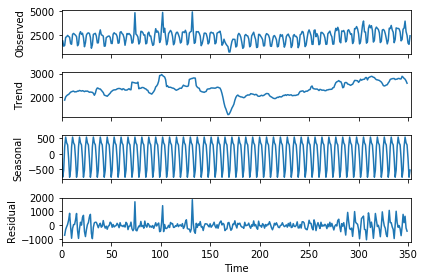

In [31]:
## ВАШ КОД для проверки стационарности ряда ##
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [42]:
train_df.index = pd.to_datetime(train_df.index)

train_df['y_box'], lmbda = stats.boxcox([1 if x == 0 else x for x in train_df['y']])
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])


Оптимальный параметр преобразования Бокса-Кокса: 0.732841
Критерий Дики-Фуллера: p=0.107392


In [43]:
ps = range(0, 4)
d=1
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)


from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)



results = []
best_aic = float("inf")



for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

(0, 0, 0, 0)
wrong parameters: (0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 3, 0)
(0, 0, 3, 1)
(0, 0, 4, 0)
(0, 0, 4, 1)
(0, 0, 5, 0)
(0, 0, 5, 1)
(0, 0, 6, 0)
(0, 0, 6, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 1, 3, 0)
(0, 1, 3, 1)
(0, 1, 4, 0)
(0, 1, 4, 1)
(0, 1, 5, 0)
(0, 1, 5, 1)
(0, 1, 6, 0)
(0, 1, 6, 1)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 2, 0)
(0, 2, 2, 1)
(0, 2, 3, 0)
(0, 2, 3, 1)
(0, 2, 4, 0)
(0, 2, 4, 1)
(0, 2, 5, 0)
(0, 2, 5, 1)
(0, 2, 6, 0)
(0, 2, 6, 1)
(0, 3, 0, 0)
(0, 3, 0, 1)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 2, 0)
(0, 3, 2, 1)
(0, 3, 3, 0)
(0, 3, 3, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 3, 4, 0)
(0, 3, 4, 1)
(0, 3, 5, 0)
(0, 3, 5, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 3, 6, 0)
(0, 3, 6, 1)
(0, 4, 0, 0)
(0, 4, 0, 1)
(0, 4, 1, 0)
(0, 4, 1, 1)
(0, 4, 2, 0)
(0, 4, 2, 1)
(0, 4, 3, 0)
(0, 4, 3, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 4, 4, 0)
(0, 4, 4, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 4, 5, 0)
(0, 4, 5, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 4, 6, 0)
(0, 4, 6, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 2, 0)
(1, 0, 2, 1)
(1, 0, 3, 0)
(1, 0, 3, 1)
(1, 0, 4, 0)
(1, 0, 4, 1)
(1, 0, 5, 0)
(1, 0, 5, 1)
(1, 0, 6, 0)
(1, 0, 6, 1)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 1, 2, 0)
(1, 1, 2, 1)
(1, 1, 3, 0)
(1, 1, 3, 1)
(1, 1, 4, 0)
(1, 1, 4, 1)
(1, 1, 5, 0)
(1, 1, 5, 1)
(1, 1, 6, 0)
(1, 1, 6, 1)
(1, 2, 0, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 0, 1)
(1, 2, 1, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 1, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 2, 0)
(1, 2, 2, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 3, 0)
(1, 2, 3, 1)
(1, 2, 4, 0)
(1, 2, 4, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 2, 5, 0)
(1, 2, 5, 1)
(1, 2, 6, 0)
(1, 2, 6, 1)
(1, 3, 0, 0)
wrong parameters: (1, 3, 0, 0)
(1, 3, 0, 1)
wrong parameters: (1, 3, 0, 1)
(1, 3, 1, 0)
wrong parameters: (1, 3, 1, 0)
(1, 3, 1, 1)
wrong parameters: (1, 3, 1, 1)
(1, 3, 2, 0)
wrong parameters: (1, 3, 2, 0)
(1, 3, 2, 1)
wrong parameters: (1, 3, 2, 1)
(1, 3, 3, 0)
wrong parameters: (1, 3, 3, 0)
(1, 3, 3, 1)
wrong parameters: (1, 3, 3, 1)
(1, 3, 4, 0)
wrong parameters: (1, 3, 4, 0)
(1, 3, 4, 1)
wrong parameters: (1, 3, 4, 1)
(1, 3, 5, 0)
wrong parameters: (1, 3, 5, 0)
(1, 3, 5, 1)
wrong parameters: (1, 3, 5, 1)
(1, 3, 6, 0)
wrong parameters: (1, 3, 6, 0)
(1, 3, 6, 1)
wrong parameters: (1, 3, 6, 1)
(1, 4, 0, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 0, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 1, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 1, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 2, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 2, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 3, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 3, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 4, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 4, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 5, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 5, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 6, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 4, 6, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 0, 0, 0)
(2, 0, 0, 1)
(2, 0, 1, 0)
(2, 0, 1, 1)
(2, 0, 2, 0)
(2, 0, 2, 1)
(2, 0, 3, 0)
(2, 0, 3, 1)
(2, 0, 4, 0)
(2, 0, 4, 1)
(2, 0, 5, 0)
(2, 0, 5, 1)
(2, 0, 6, 0)
(2, 0, 6, 1)
(2, 1, 0, 0)
(2, 1, 0, 1)
(2, 1, 1, 0)
(2, 1, 1, 1)
(2, 1, 2, 0)
(2, 1, 2, 1)
(2, 1, 3, 0)
(2, 1, 3, 1)
(2, 1, 4, 0)
(2, 1, 4, 1)
(2, 1, 5, 0)
(2, 1, 5, 1)
(2, 1, 6, 0)
(2, 1, 6, 1)
(2, 2, 0, 0)
(2, 2, 0, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning:

invalid value encountered in sqrt



(2, 2, 1, 0)
(2, 2, 1, 1)
(2, 2, 2, 0)
(2, 2, 2, 1)
(2, 2, 3, 0)
(2, 2, 3, 1)
(2, 2, 4, 0)
(2, 2, 4, 1)
(2, 2, 5, 0)
(2, 2, 5, 1)
(2, 2, 6, 0)
(2, 2, 6, 1)
(2, 3, 0, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 0, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 1, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 1, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 2, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 2, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 3, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 3, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 4, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 4, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 5, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 5, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 6, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 3, 6, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 0, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 0, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 1, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 1, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 2, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 2, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 3, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 3, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 4, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 4, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 5, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 5, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 6, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(2, 4, 6, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 0, 0, 0)
(3, 0, 0, 1)
(3, 0, 1, 0)
(3, 0, 1, 1)
(3, 0, 2, 0)
(3, 0, 2, 1)
(3, 0, 3, 0)
(3, 0, 3, 1)
(3, 0, 4, 0)
(3, 0, 4, 1)
(3, 0, 5, 0)
(3, 0, 5, 1)
(3, 0, 6, 0)
(3, 0, 6, 1)
(3, 1, 0, 0)
(3, 1, 0, 1)
(3, 1, 1, 0)
(3, 1, 1, 1)
(3, 1, 2, 0)
(3, 1, 2, 1)
(3, 1, 3, 0)
(3, 1, 3, 1)
(3, 1, 4, 0)
(3, 1, 4, 1)
(3, 1, 5, 0)
(3, 1, 5, 1)
(3, 1, 6, 0)
(3, 1, 6, 1)
(3, 2, 0, 0)
wrong parameters: (3, 2, 0, 0)
(3, 2, 0, 1)
wrong parameters: (3, 2, 0, 1)
(3, 2, 1, 0)
wrong parameters: (3, 2, 1, 0)
(3, 2, 1, 1)
wrong parameters: (3, 2, 1, 1)
(3, 2, 2, 0)
wrong parameters: (3, 2, 2, 0)
(3, 2, 2, 1)
wrong parameters: (3, 2, 2, 1)
(3, 2, 3, 0)
wrong parameters: (3, 2, 3, 0)
(3, 2, 3, 1)
wrong parameters: (3, 2, 3, 1)
(3, 2, 4, 0)
wrong parameters: (3, 2, 4, 0)
(3, 2, 4, 1)
wrong parameters: (3, 2, 4, 1)
(3, 2, 5, 0)
wrong parameters: (3, 2, 5, 0)
(3, 2, 5, 1)
wrong parameters: (3, 2, 5, 1)
(3, 2, 6, 0)
wrong parameters: (3, 2, 6, 0)
(3, 2, 6, 1)
wrong parameters: (3, 2, 6, 1)
(3, 3, 0, 0)
(3, 3, 

/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 3, 1, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 3, 1, 1)
(3, 3, 2, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 3, 2, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 3, 3, 0)
(3, 3, 3, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 3, 4, 0)
(3, 3, 4, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 3, 5, 0)
(3, 3, 5, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 3, 6, 0)
(3, 3, 6, 1)
(3, 4, 0, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 0, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 1, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 1, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 2, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 2, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 3, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 3, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 4, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 4, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 5, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 5, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 6, 0)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3, 4, 6, 1)


/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [49]:
result_table = pd.DataFrame(results)
print(result_table)

                0            1
0    (0, 0, 0, 1)  3652.592754
1    (0, 0, 1, 0)  3693.204865
2    (0, 0, 1, 1)  3654.074535
3    (0, 0, 2, 0)  3666.015731
4    (0, 0, 2, 1)  3654.040495
5    (0, 0, 3, 0)  3644.126223
6    (0, 0, 3, 1)  3642.808568
7    (0, 0, 4, 0)  3643.728691
8    (0, 0, 4, 1)  3644.781366
9    (0, 0, 5, 0)  3644.604478
10   (0, 0, 5, 1)  3646.526516
11   (0, 0, 6, 0)  3646.441409
12   (0, 0, 6, 1)  3648.428354
13   (0, 1, 0, 0)  3697.922391
14   (0, 1, 0, 1)  3591.576807
15   (0, 1, 1, 0)  3627.145201
16   (0, 1, 1, 1)  3593.413929
17   (0, 1, 2, 0)  3604.069506
18   (0, 1, 2, 1)  3594.060894
19   (0, 1, 3, 0)  3587.317366
20   (0, 1, 3, 1)  3588.705253
21   (0, 1, 4, 0)  3588.766027
22   (0, 1, 4, 1)  3590.701967
23   (0, 1, 5, 0)  3590.665792
24   (0, 1, 5, 1)  3592.666158
25   (0, 1, 6, 0)  3592.665215
26   (0, 1, 6, 1)  3594.664051
27   (0, 2, 0, 0)  3681.624388
28   (0, 2, 0, 1)  3572.340801
29   (0, 2, 1, 0)  3619.404934
..            ...          ...
221  (3,

In [45]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(3, 1, 1)x(3, 1, 0, 7)   Log Likelihood               -1769.115
Date:                           Sun, 11 Mar 2018   AIC                           3554.229
Time:                                   12:25:17   BIC                           3585.161
Sample:                               01-01-1970   HQIC                          3566.538
                                    - 01-01-1970                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4810      0.036     13.196      0.000       0.410       0.552
ar.L2         -0.0516      0.056     -0.921